In [7]:
#Importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from ipywidgets import interact, interactive, fixed, interact_manual
#from utils import *

#import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [8]:
def plot_well_logs_comparison(df, well,lithology_col,predicted_col,colors,lithology,dz=100,figsize=(11,12)):
    fig, axes = plt.subplots(1, 6, figsize=figsize)

    # Definindo o limite vertical e adicionando grade
    for ax in axes:
        ax.set_ylim(df[df.WELL == well].DEPTH_MD.max() + dz, df[df.WELL == well].DEPTH_MD.min() - dz)
        ax.grid()

    # Primeiro gráfico: GR com CALI
    axes[0].plot(df[df.WELL == well].GR, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='GR')
    ax0 = axes[0].twiny()
    ax0.plot(df[df.WELL == well].CALI, df[df.WELL == well].DEPTH_MD, c='r', ls='--', lw=0.8, label='CALI')
    ax0.legend(loc='upper left', fontsize=8)

    # Segundo gráfico: RDEP e RMED
    axes[1].plot(df[df.WELL == well].RDEP, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RILD')
    axes[1].plot(df[df.WELL == well].RMED, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='RILM', ls='--')
    axes[1].set_xscale('log')

    # Terceiro gráfico: DTC
    axes[2].plot(df[df.WELL == well].DTC, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='DTC')

    # Quarto gráfico: RHOB com NPHI
    axes[3].plot(df[df.WELL == well].RHOB, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RHOB')
    ax3 = axes[3].twiny()
    ax3.plot(df[df.WELL == well].NPHI, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='NPHI', ls='--')


    for i,j in zip(lithology,colors):

        axes[4].fill_betweenx(df[df.WELL == well].DEPTH_MD, 0,
                           1,
                           where=(df[df.WELL == well][lithology_col] == i),
                           color=j, alpha=1,label=i)

    for i,j in zip(lithology,colors):

        axes[5].fill_betweenx(df[df.WELL == well].DEPTH_MD, 0,
                           1,
                           where=(df[df.WELL == well][predicted_col]== i),
                           color=j, alpha=1,label=i)

    # Adicionando legendas em todos os gráficos
    for ax in axes:
        ax.legend(fontsize=8, loc='upper right')

    axes[4].legend(fontsize=5)
    axes[5].legend(fontsize=5)

    # Ajustando o layout para evitar sobreposição
    fig.tight_layout()

    return fig, axes

In [9]:
colors = [
    "#fcf444",  # light yellow/pastel yellow
    "#84fc04",  # lime green / neon green
    "#84b4b4",  # blue-green
    "#340cfc",  # deep blue / electric blue
    "#046ccc",  # cyan blue
    "#c0fcfc",  # light cyan
    "#88fcfc",  # very light cyan / soft turquoise
    "#6cb4cc",  # light sky blue / light cerulean blue
    "#dc1cfc",  # bright magenta / electric purple
    "#1005bc",  # deep blue
    "#dedede",  # light gray
    "#fc0c34"   # gainsboro
]

lithology = [
    "Sandstone (Arenito)",
    "Sandstone/Shale (Arenito)",
    "Shale (Argilito)",
    "Marl (Marga)",
    "Dolomite (Dolomita)",
    "Limestone (Calcário)",
    "Chalk (Giz)",
    "Halite (Halita)",
    "Anhydrite (Anidrita)",
    "Tuff (Tufo)",
    "Coal (Carvão)",
    "Basement (Substrato)"
]

litologia_dict = {
    30000: 'Sandstone (Arenito)',
    65030: 'Sandstone/Shale (Arenito/Argilito)',
    65000: 'Shale (Argilito)',
    80000: 'Marl (Marga)',
    74000: 'Dolomite (Dolomita)',
    70000: 'Limestone (Calcário)',
    70032: 'Chalk (Giz)',
    88000: 'Halite (Halita)',
    86000: 'Anhydrite (Anidrita)',
    99000: 'Tuff (Tufo)',
    90000: 'Coal (Carvão)',
    93000: 'Basement (Substrato)'
}

In [10]:
dataset = pd.read_csv('/content/drive/MyDrive/train_dataset_proc.csv',index_col=0)
dataset.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY,RMED_log,RDEP_log
4238,15/9-13,1138.704,19.322735,1.013309,1.091499,1.774626,55.892757,0.765867,147.837677,30000,NORDLAND GP.,6,Sandstone (Arenito),0.005742,0.038023
4239,15/9-13,1138.856,18.613674,1.088184,1.122706,1.800986,60.929138,0.800262,142.382431,65000,NORDLAND GP.,6,Shale (Argilito),0.036703,0.050266
4240,15/9-13,1139.008,18.212072,1.127155,1.148141,1.817696,62.117264,0.765957,138.258331,65000,NORDLAND GP.,6,Shale (Argilito),0.051984,0.059995
4241,15/9-13,1139.160,18.134182,1.141467,1.170984,1.829333,61.010860,0.702521,139.198914,65000,NORDLAND GP.,6,Shale (Argilito),0.057463,0.068551
4242,15/9-13,1139.312,18.033762,1.138007,1.184080,1.813854,58.501236,0.639708,144.290085,65000,NORDLAND GP.,6,Shale (Argilito),0.056145,0.073381


In [11]:
blind = pd.read_csv('/content/drive/MyDrive/blind_dataset_proc.csv',index_col=0)
blind.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY,RMED_log,RDEP_log
234896,25/4-5,853.302805,19.158823,1.163803,1.584162,1.888391,56.317116,0.601983,141.181976,65000,HORDALAND GP.,5,Shale (Argilito),0.065880,0.199800
234897,25/4-5,853.454805,19.146057,1.147559,1.578194,1.827109,51.759800,0.591833,141.277908,65000,HORDALAND GP.,5,Shale (Argilito),0.059775,0.198160
234898,25/4-5,853.606805,19.135382,1.138462,1.580893,1.759068,53.405884,0.582091,141.153244,65000,HORDALAND GP.,5,Shale (Argilito),0.056319,0.198902
234899,25/4-5,853.758805,19.131018,1.134463,1.593340,1.701803,51.774151,0.571569,142.185715,65000,HORDALAND GP.,5,Shale (Argilito),0.054790,0.202308
234900,25/4-5,853.910805,19.134014,1.141337,1.607236,1.680071,53.915359,0.563947,141.346375,65000,HORDALAND GP.,5,Shale (Argilito),0.057414,0.206080


In [12]:
#Verificando as colunas do dataset
dataset.columns

Index(['WELL', 'DEPTH_MD', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC',
       'FORCE_2020_LITHOFACIES_LITHOLOGY', 'GROUP', 'GROUP_num', 'LITHOLOGY',
       'RMED_log', 'RDEP_log'],
      dtype='object')

In [13]:
#Separando as variáveis de entrada e saída
cols = ['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC'
        , 'GROUP_num', 'RMED_log', 'RDEP_log']

X = dataset[cols]
y = dataset['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [14]:
#Separando conjunto de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [16]:
#média e desvio padrão salvo
scaler.mean_,scaler.var_

(array([ 12.08966936,   5.06969507,   4.67958775,   2.34542986,
         74.43478828,   0.3372253 , 103.5123173 ,   6.44603193,
          0.35627613,   0.31896462]),
 array([9.64840346e+00, 9.62799795e+02, 1.24796075e+03, 5.85686843e-02,
        1.20906274e+03, 1.86834091e-02, 7.62815526e+02, 1.04897978e+01,
        1.90685925e-01, 1.79932047e-01]))

### Experimentos com a regressão logística

In [17]:
lr = LogisticRegression()
lr.fit(scaler.transform(X_train),y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [18]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,lr.predict(scaler.transform(X_train)),
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.67      0.70      0.69     36000
Sandstone/Shale (Arenito/Argilito)       0.81      0.97      0.88    170366
                  Shale (Argilito)       0.51      0.10      0.16     29433
                      Marl (Marga)       0.56      0.51      0.54     12965
               Dolomite (Dolomita)       0.66      0.58      0.62      4924
              Limestone (Calcário)       0.00      0.00      0.00       539
                       Chalk (Giz)       0.31      0.01      0.01      5631
                   Halite (Halita)       0.91      0.88      0.89       176
              Anhydrite (Anidrita)       0.00      0.00      0.00        17
                       Tuff (Tufo)       0.65      0.48      0.56      1647
                     Coal (Carvão)       0.70      0.41      0.52        73
              Basement (Substrato)       0.00      0.00      0.00      1959

          

In [19]:
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],lr.predict(scaler.transform(blind[cols]))))

              precision    recall  f1-score   support

       30000       0.78      0.53      0.63     10461
       65000       0.74      0.99      0.84     30951
       65030       0.54      0.03      0.06      5662
       70000       0.36      0.48      0.41      3375
       70032       0.00      0.00      0.00         0
       74000       0.00      0.00      0.00        26
       80000       0.00      0.00      0.00      4407
       90000       0.90      0.25      0.39       176
       99000       0.00      0.00      0.00       247

    accuracy                           0.69     55305
   macro avg       0.37      0.25      0.26     55305
weighted avg       0.64      0.69      0.62     55305



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

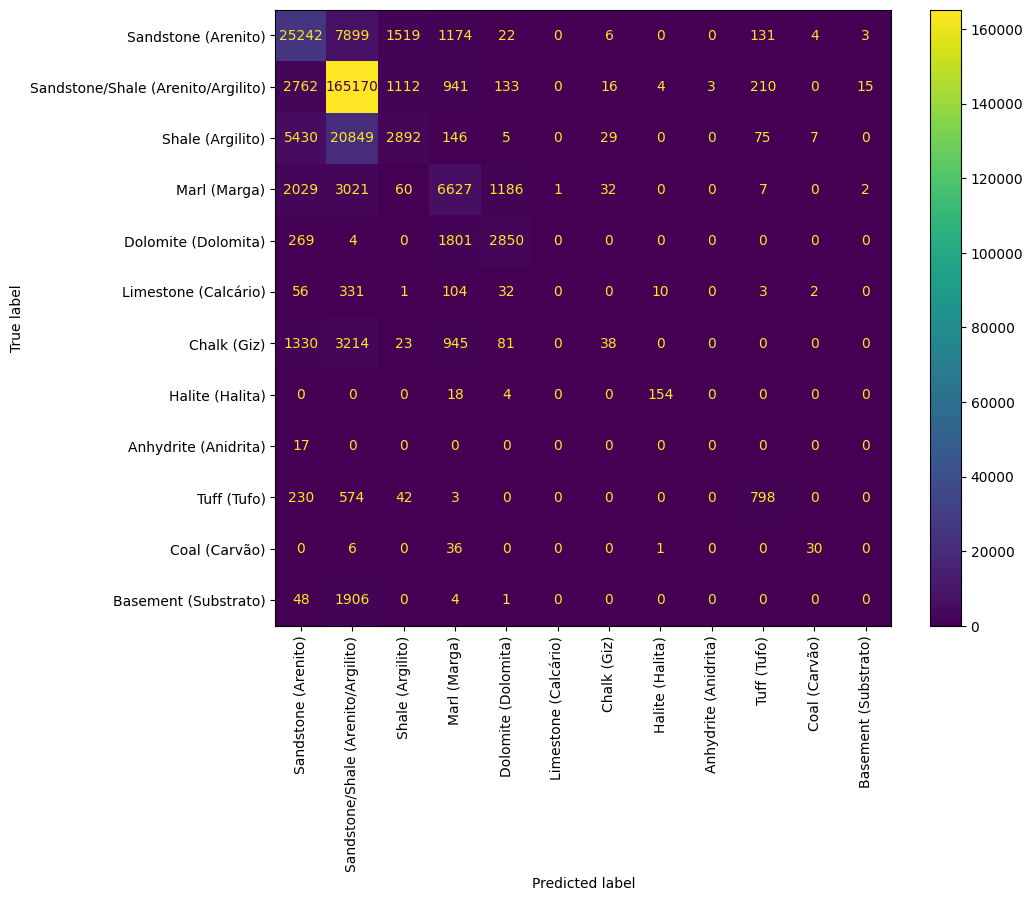

In [20]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(y_train,lr.predict(scaler.transform(X_train))),
                              display_labels=litologia_dict.values())

disp.plot(ax=axes)

axes.set_xticklabels(litologia_dict.values(),rotation=90)

fig.show()

In [21]:
#usando o map para transform as labels em strings
dataset['log_reg'] = list(map(litologia_dict.get,lr.predict(scaler.transform(X))))
blind['log_reg'] = list(map(litologia_dict.get,lr.predict(scaler.transform(blind[cols]))))

interactive(children=(Dropdown(description='well', options=('25/4-5', '25/9-1', '31/4-5', '33/9-1', '33/9-17')…

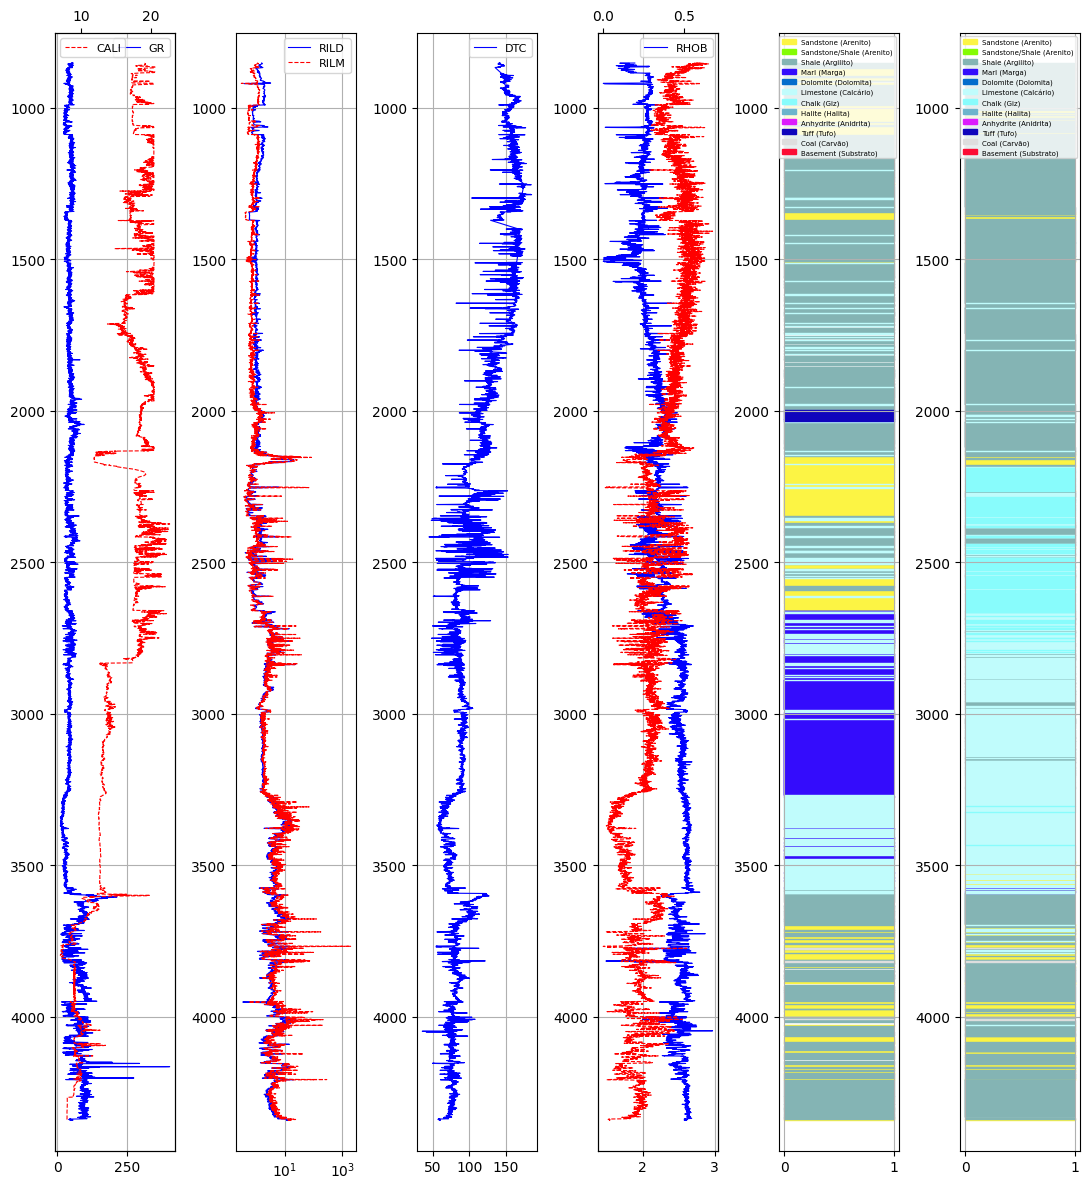

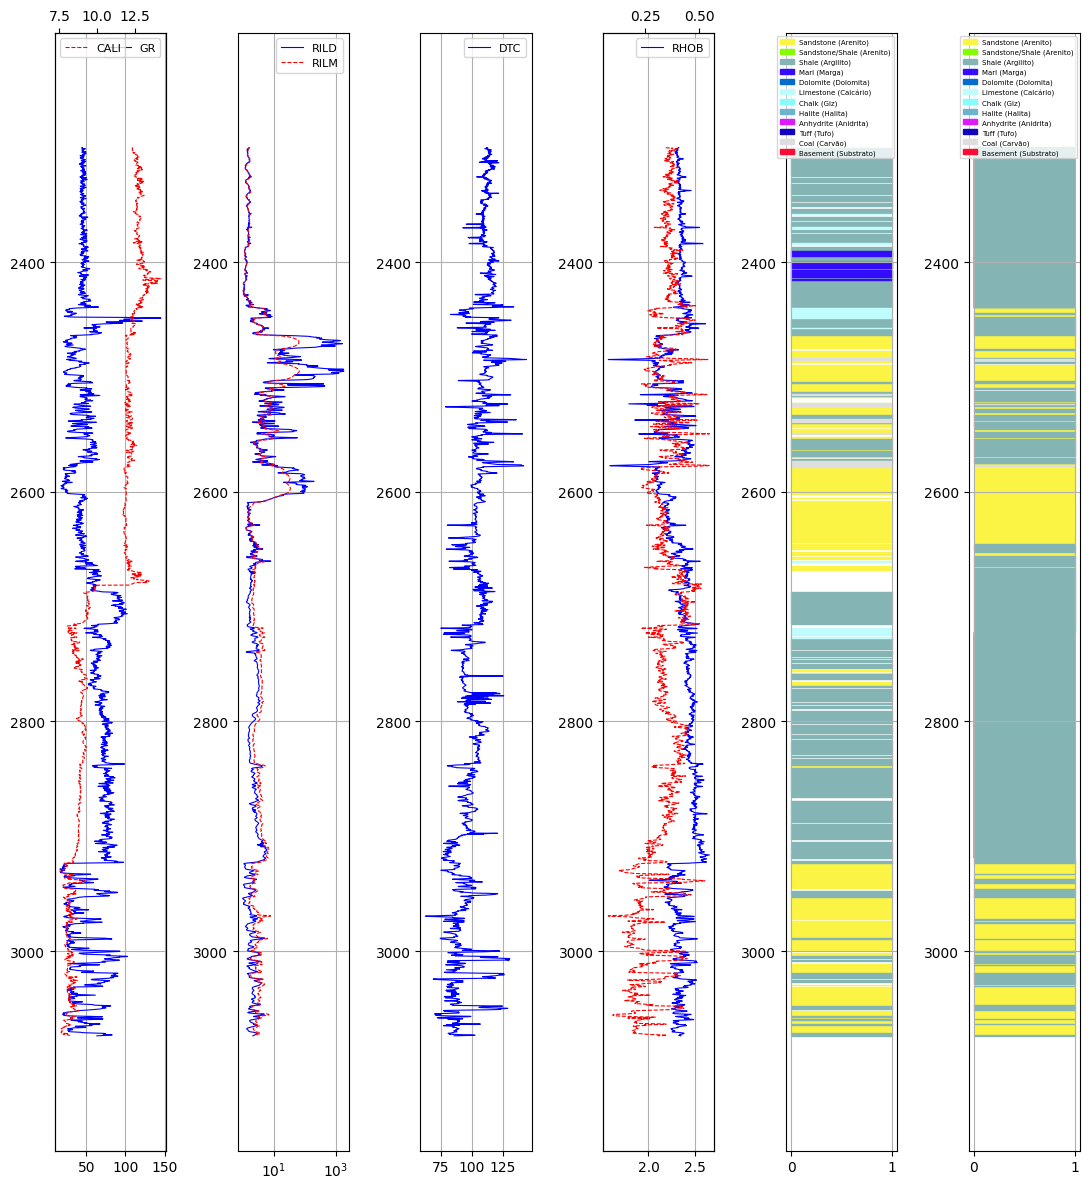

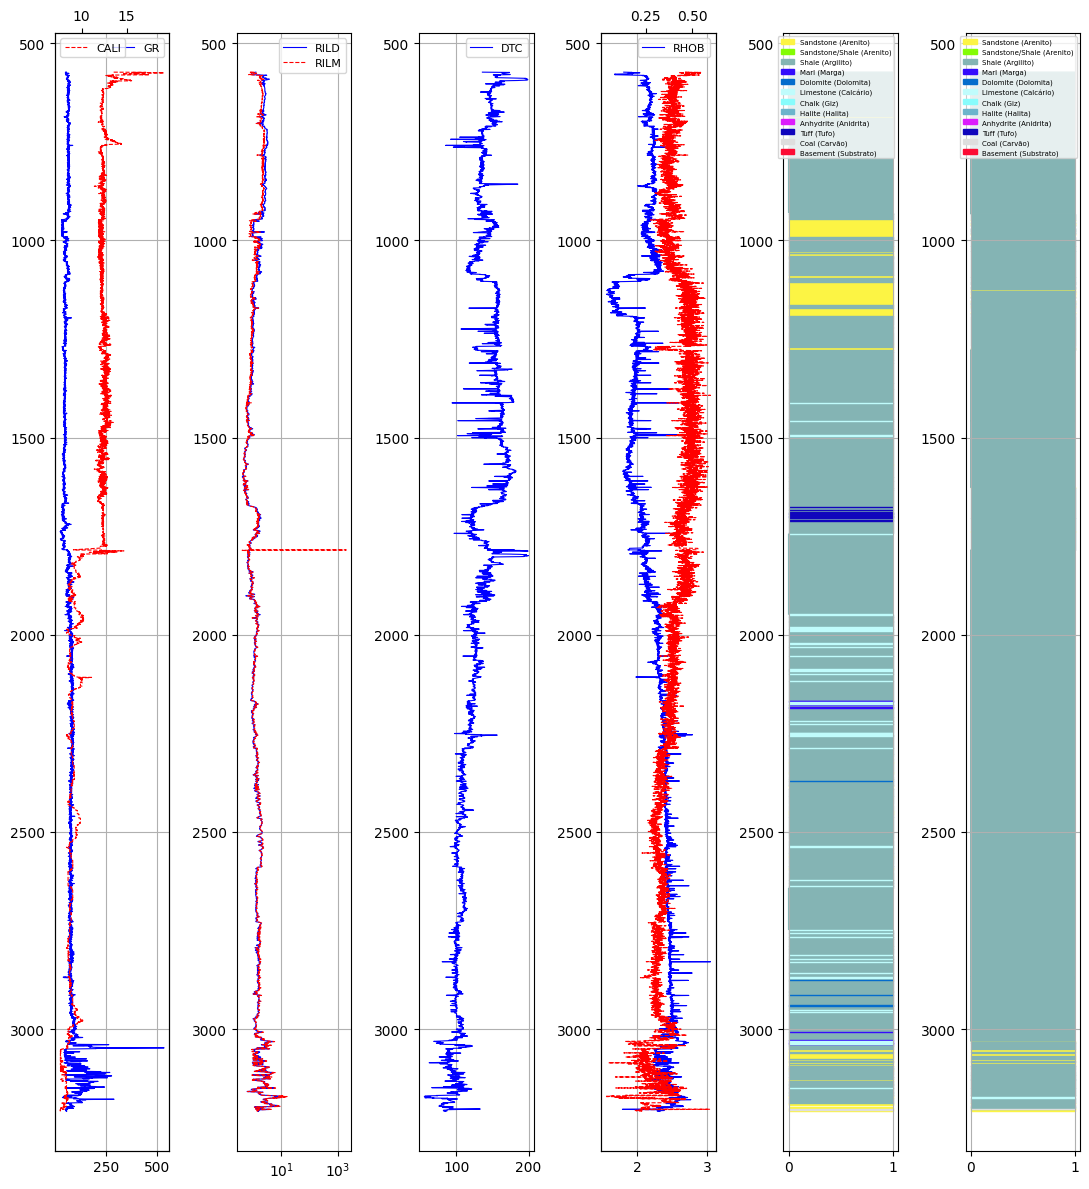

In [22]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='log_reg',colors=colors,lithology=lithology,dz=100)

### Aplicando o KNN

In [23]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(scaler.transform(X_train),y_train)

KNeighborsClassifier(n_neighbors=7)

In [24]:
y_knn_pred = knn.predict(scaler.transform(X_train))
y_knn_pred_test = knn.predict(scaler.transform(X_test))

In [25]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,y_knn_pred,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.91      0.92      0.92     36000
Sandstone/Shale (Arenito/Argilito)       0.95      0.98      0.96    170366
                  Shale (Argilito)       0.85      0.81      0.83     29433
                      Marl (Marga)       0.93      0.79      0.85     12965
               Dolomite (Dolomita)       0.94      0.94      0.94      4924
              Limestone (Calcário)       0.84      0.38      0.53       539
                       Chalk (Giz)       0.88      0.80      0.84      5631
                   Halite (Halita)       0.87      0.89      0.88       176
              Anhydrite (Anidrita)       0.93      0.82      0.88        17
                       Tuff (Tufo)       0.90      0.71      0.79      1647
                     Coal (Carvão)       0.85      0.97      0.90        73
              Basement (Substrato)       0.87      0.81      0.84      1959

          

In [26]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_test,y_knn_pred_test,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.88      0.89      0.89      8984
Sandstone/Shale (Arenito/Argilito)       0.94      0.97      0.95     42478
                  Shale (Argilito)       0.80      0.75      0.78      7493
                      Marl (Marga)       0.89      0.74      0.81      3184
               Dolomite (Dolomita)       0.92      0.92      0.92      1249
              Limestone (Calcário)       0.66      0.26      0.37       135
                       Chalk (Giz)       0.84      0.73      0.78      1471
                   Halite (Halita)       0.88      0.90      0.89        39
              Anhydrite (Anidrita)       0.50      0.33      0.40         3
                       Tuff (Tufo)       0.86      0.66      0.75       405
                     Coal (Carvão)       0.94      0.88      0.91        17
              Basement (Substrato)       0.83      0.76      0.79       475

          

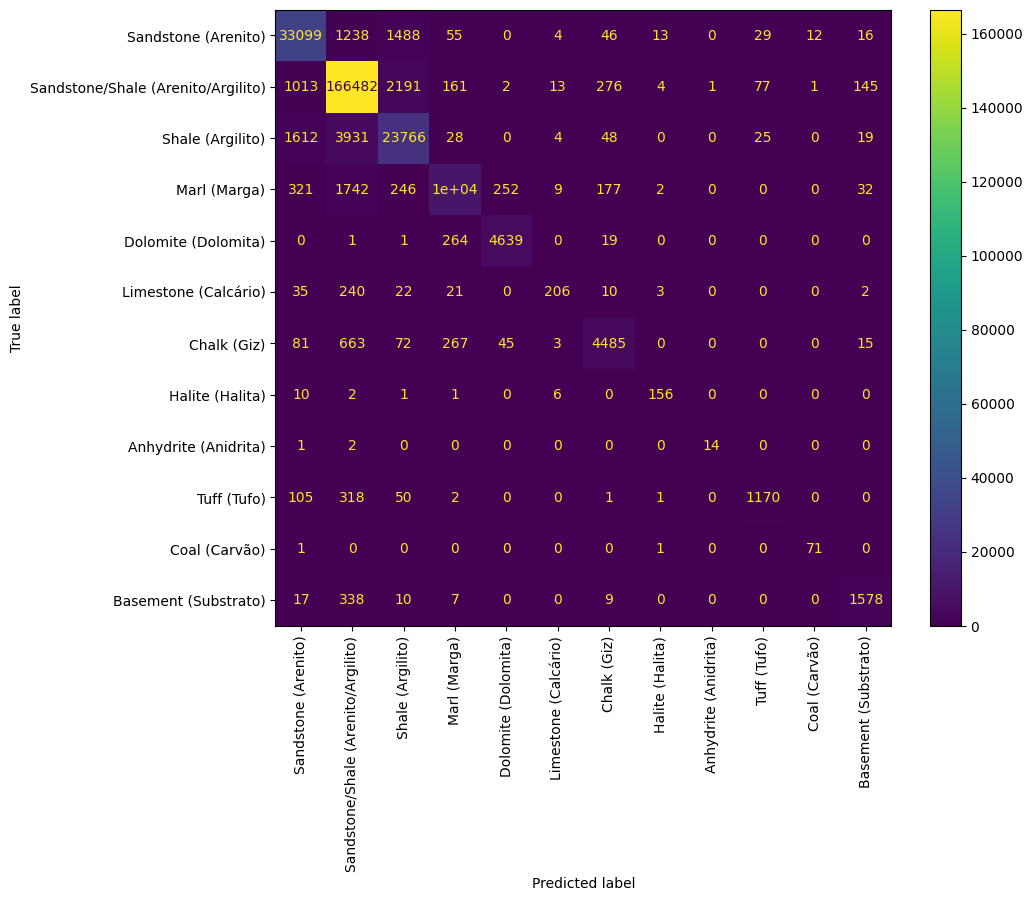

In [27]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(y_train,y_knn_pred),
                              display_labels=litologia_dict.values())

disp.plot(ax=axes)

axes.set_xticklabels(litologia_dict.values(),rotation=90)

fig.show()

In [28]:
y_blind = knn.predict(scaler.transform(blind[cols]))

In [29]:
keys_blind = sorted(np.unique(y_blind))
dic_blind = {chave: litologia_dict[chave] for chave in keys_blind}

In [30]:
litologia_dict

{30000: 'Sandstone (Arenito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 65000: 'Shale (Argilito)',
 80000: 'Marl (Marga)',
 74000: 'Dolomite (Dolomita)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 88000: 'Halite (Halita)',
 86000: 'Anhydrite (Anidrita)',
 99000: 'Tuff (Tufo)',
 90000: 'Coal (Carvão)',
 93000: 'Basement (Substrato)'}

In [31]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind,target_names=list(dic_blind.values())))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.76      0.56      0.64     10461
                  Shale (Argilito)       0.74      0.84      0.78     30951
Sandstone/Shale (Arenito/Argilito)       0.21      0.24      0.23      5662
              Limestone (Calcário)       0.52      0.43      0.47      3375
                       Chalk (Giz)       0.00      0.00      0.00         0
               Dolomite (Dolomita)       0.03      0.08      0.04        26
                      Marl (Marga)       0.48      0.22      0.30      4407
              Anhydrite (Anidrita)       0.00      0.00      0.00         0
                     Coal (Carvão)       0.36      0.47      0.41       176
                       Tuff (Tufo)       0.04      0.14      0.06       247

                          accuracy                           0.64     55305
                         macro avg       0.32      0.30      0.29     55305
          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


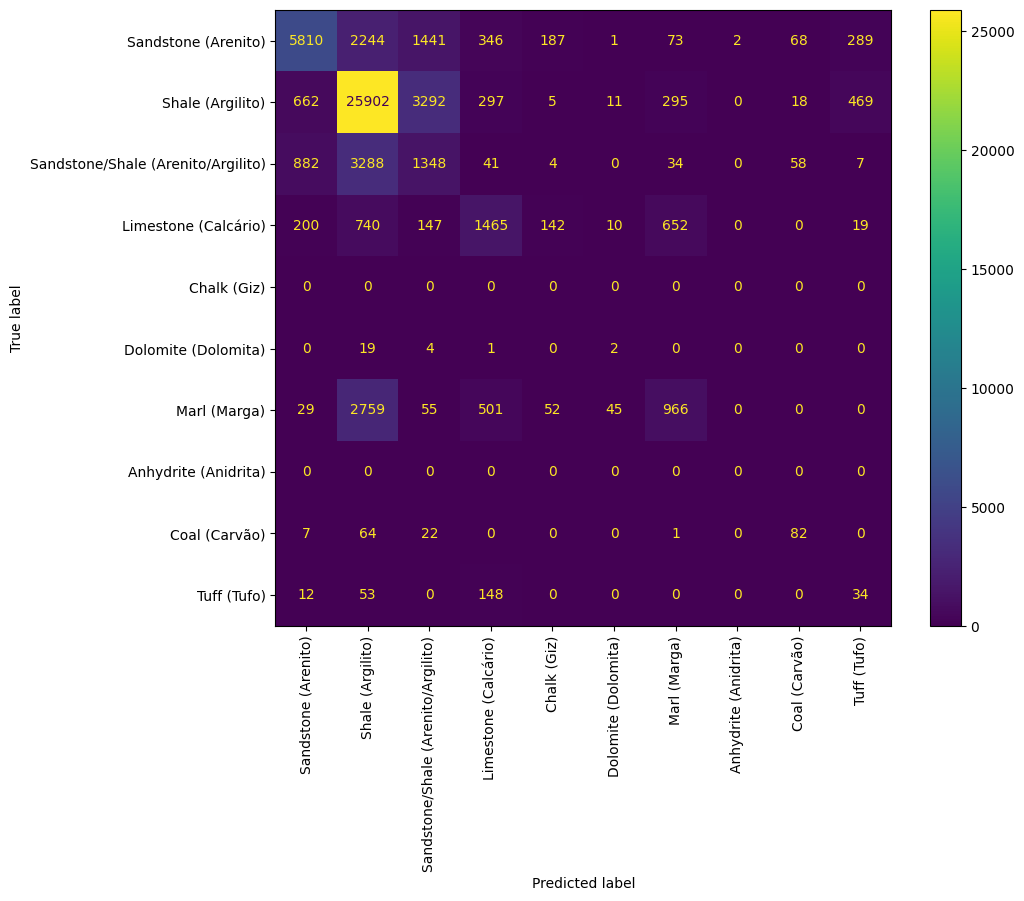

In [32]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind),
                              display_labels=list(dic_blind.values()))

disp.plot(ax=axes)

axes.set_xticklabels(dic_blind.values(),rotation=90)

fig.show()

In [33]:
#usando o map para transform as labels em strings
dataset['knn'] = list(map(litologia_dict.get,knn.predict(scaler.transform(X))))
blind['knn'] = list(map(litologia_dict.get,y_blind))

interactive(children=(Dropdown(description='well', options=('25/4-5', '25/9-1', '31/4-5', '33/9-1', '33/9-17')…

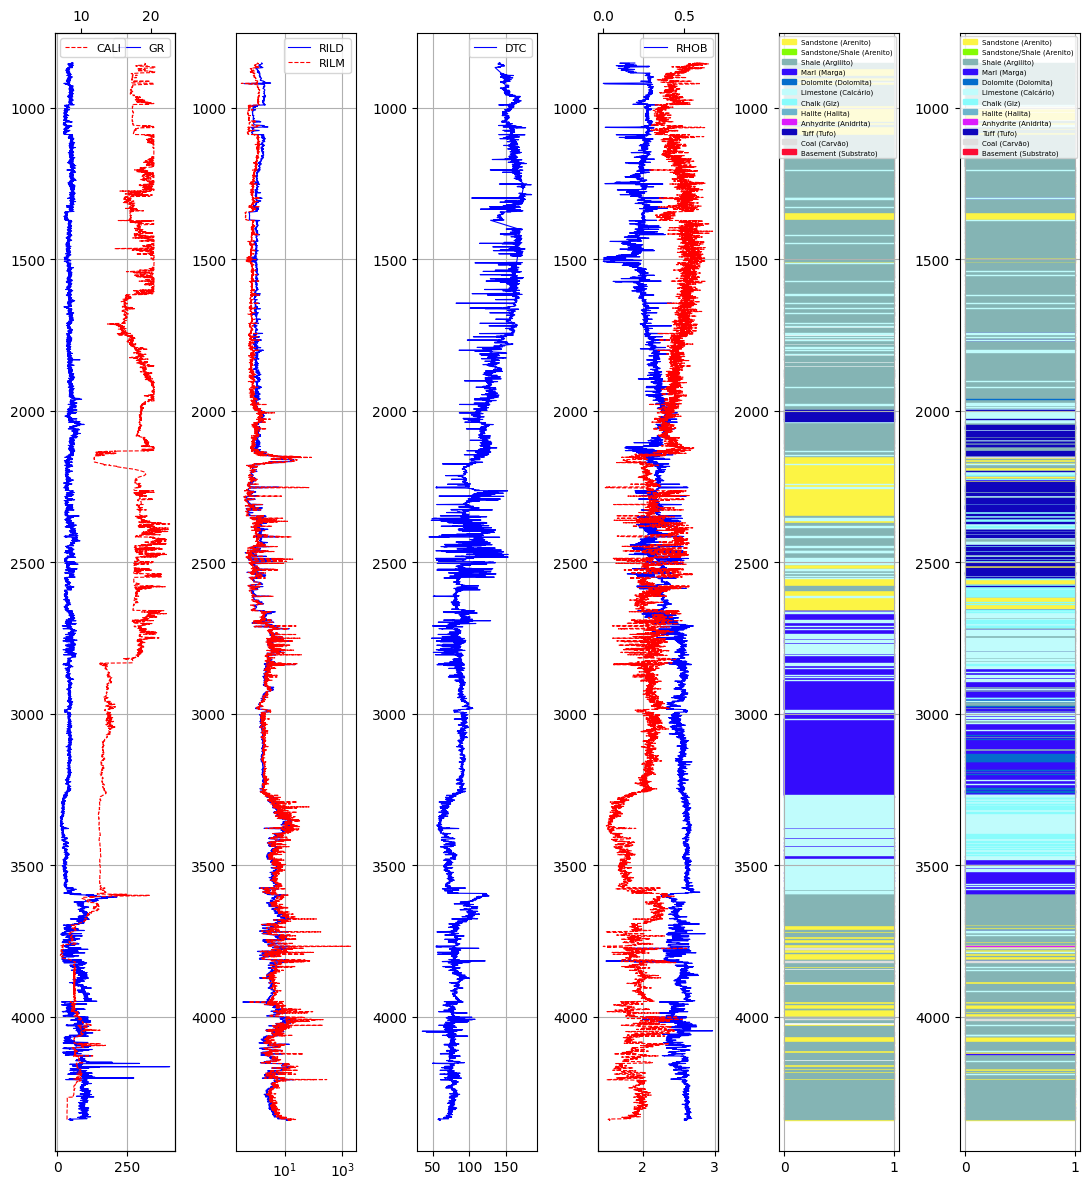

In [34]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='knn',colors=colors,lithology=lithology,dz=100)

In [35]:
mlp = MLPClassifier(alpha=0.001,activation='tanh',hidden_layer_sizes=(30,15,15),max_iter=200)

mlp.fit(scaler.transform(X_train),y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 15, 15))

In [36]:
y_mlp_pred = mlp.predict(scaler.transform(X_train))
y_mlp_pred_test = mlp.predict(scaler.transform(X_test))

In [37]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,y_mlp_pred,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.83      0.84      0.83     36000
Sandstone/Shale (Arenito/Argilito)       0.89      0.96      0.92    170366
                  Shale (Argilito)       0.67      0.52      0.59     29433
                      Marl (Marga)       0.84      0.64      0.73     12965
               Dolomite (Dolomita)       0.85      0.82      0.83      4924
              Limestone (Calcário)       0.21      0.01      0.01       539
                       Chalk (Giz)       0.63      0.44      0.52      5631
                   Halite (Halita)       0.88      0.93      0.90       176
              Anhydrite (Anidrita)       0.71      0.29      0.42        17
                       Tuff (Tufo)       0.81      0.56      0.66      1647
                     Coal (Carvão)       0.87      0.82      0.85        73
              Basement (Substrato)       0.73      0.41      0.53      1959

          

In [38]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_test,y_mlp_pred_test,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.82      0.83      0.83      8984
Sandstone/Shale (Arenito/Argilito)       0.89      0.96      0.92     42478
                  Shale (Argilito)       0.66      0.51      0.58      7493
                      Marl (Marga)       0.83      0.64      0.72      3184
               Dolomite (Dolomita)       0.85      0.83      0.84      1249
              Limestone (Calcário)       0.00      0.00      0.00       135
                       Chalk (Giz)       0.63      0.44      0.52      1471
                   Halite (Halita)       0.81      0.97      0.88        39
              Anhydrite (Anidrita)       0.00      0.00      0.00         3
                       Tuff (Tufo)       0.74      0.56      0.64       405
                     Coal (Carvão)       0.80      0.71      0.75        17
              Basement (Substrato)       0.71      0.41      0.52       475

          

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [39]:
y_blind = mlp.predict(scaler.transform(blind[cols]))
keys_blind = keys_blind = sorted(np.unique(y_blind))
dic_blind = {chave: litologia_dict[chave] for chave in keys_blind}

In [40]:
dic_blind

{30000: 'Sandstone (Arenito)',
 65000: 'Shale (Argilito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 80000: 'Marl (Marga)',
 90000: 'Coal (Carvão)',
 99000: 'Tuff (Tufo)'}

In [41]:
litologia_dict

{30000: 'Sandstone (Arenito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 65000: 'Shale (Argilito)',
 80000: 'Marl (Marga)',
 74000: 'Dolomite (Dolomita)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 88000: 'Halite (Halita)',
 86000: 'Anhydrite (Anidrita)',
 99000: 'Tuff (Tufo)',
 90000: 'Coal (Carvão)',
 93000: 'Basement (Substrato)'}

In [42]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind))

              precision    recall  f1-score   support

       30000       0.65      0.60      0.62     10461
       65000       0.73      0.79      0.76     30951
       65030       0.20      0.29      0.23      5662
       70000       0.55      0.35      0.43      3375
       70032       0.00      0.00      0.00         0
       74000       0.00      0.00      0.00        26
       80000       0.38      0.10      0.16      4407
       90000       0.47      0.47      0.47       176
       99000       0.10      0.13      0.12       247

    accuracy                           0.61     55305
   macro avg       0.34      0.30      0.31     55305
weighted avg       0.62      0.61      0.61     55305



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

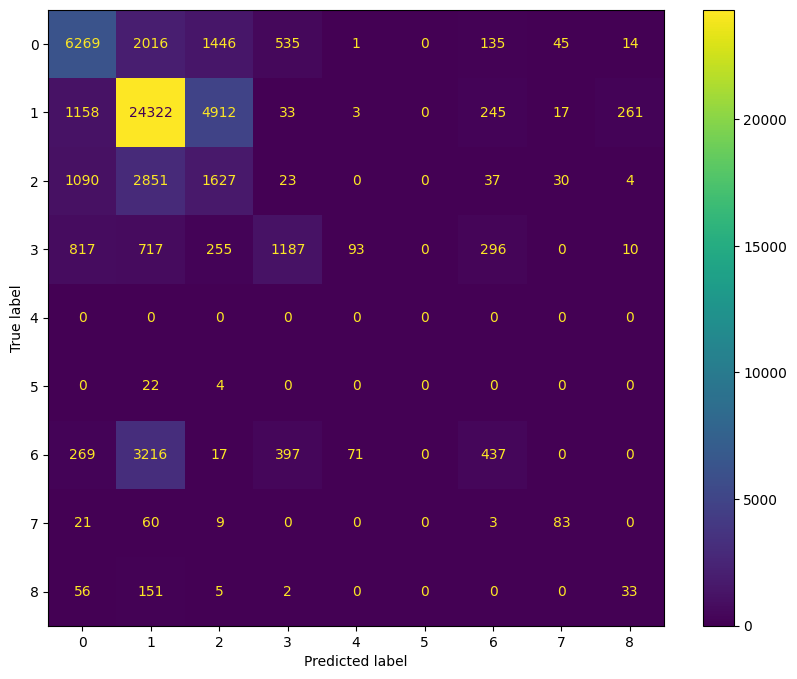

In [43]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

#disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind),
                            #   display_labels=list(dic_blind.values()))

disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind))

disp.plot(ax=axes)

#axes.set_xticklabels(dic_blind.values(),rotation=90)

fig.show()

In [44]:
#usando o map para transform as labels em strings
dataset['mlp'] = list(map(litologia_dict.get,mlp.predict(scaler.transform(X))))
blind['mlp'] = list(map(litologia_dict.get,y_blind))

interactive(children=(Dropdown(description='well', options=('25/4-5', '25/9-1', '31/4-5', '33/9-1', '33/9-17')…

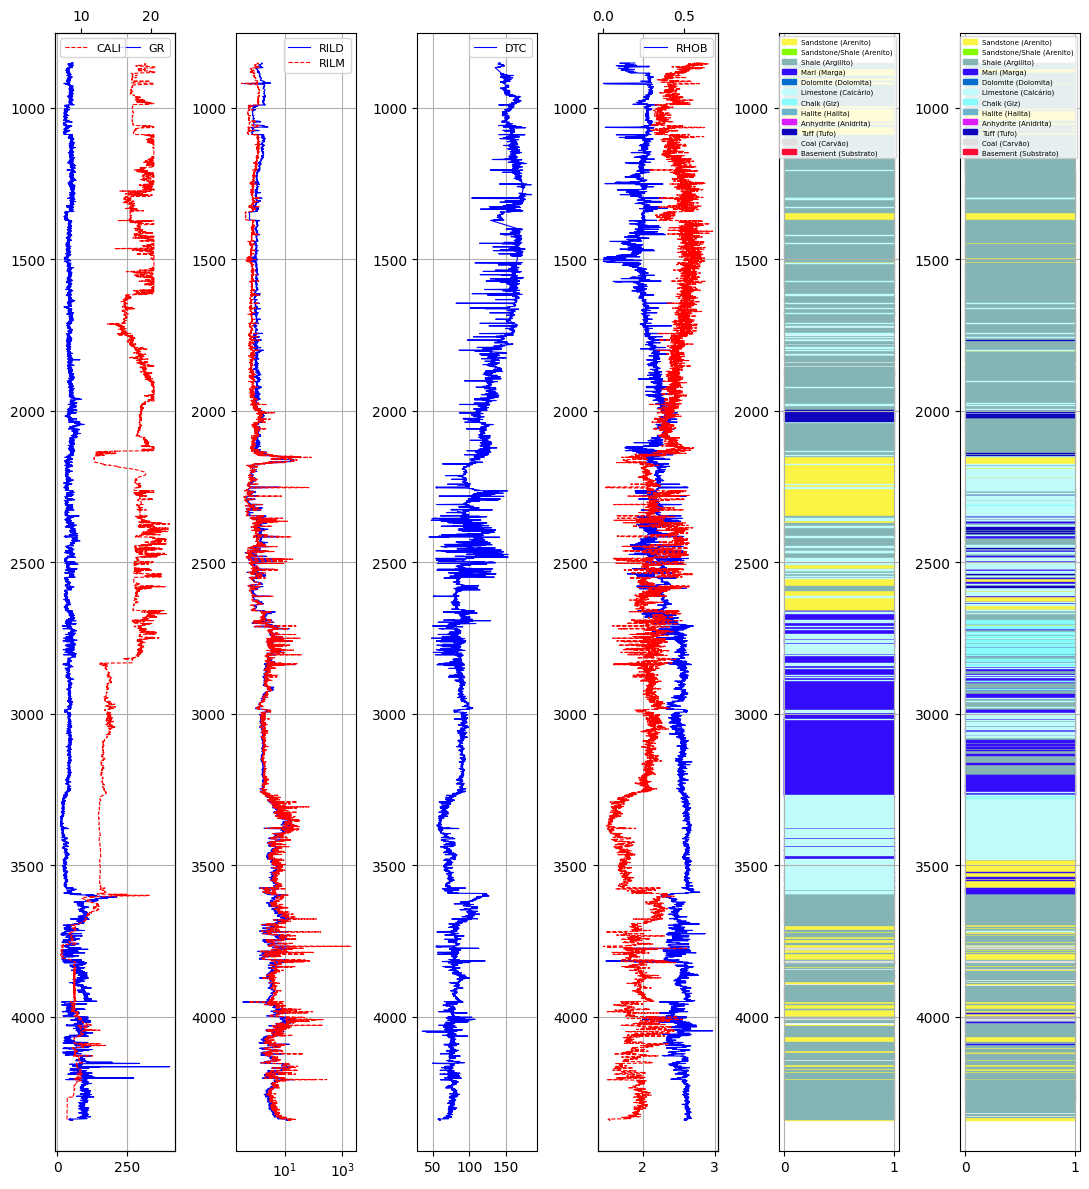

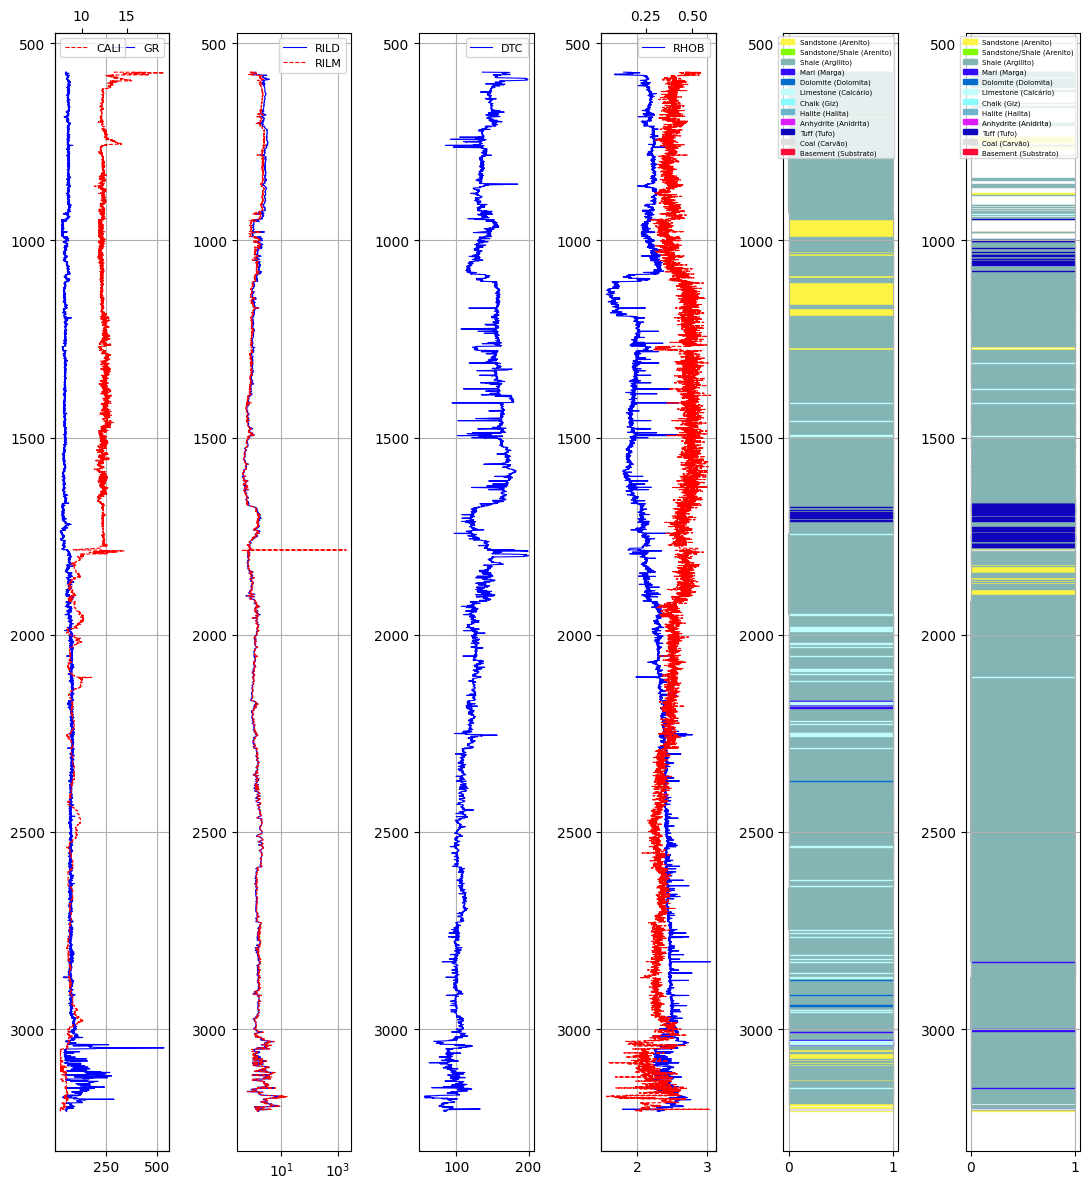

In [45]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='mlp',colors=colors,lithology=lithology,dz=100)